In [6]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 90% !important; }</style>"))

import sys
sys.path.append('../utils')
        
import tensorflow as tf
import hdf5_experiment as E
import sacred
import matplotlib.pyplot as plt

tf.__version__

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


'2.1.0'

<KeysViewHDF5 ['actions', 'checkpoints', 'observations', 'rewards', 'track', 'track_len']>


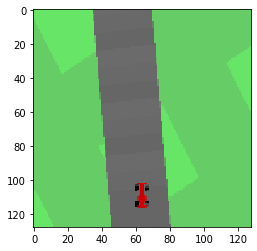

In [7]:
print(E.HD.keys())

im = E.OBSERVATIONS[0, 900]
plt.imshow(im / 255)

In [112]:
E.EX.add_config(
    SEQ_LEN = 128,
    W = 128,
    H = 128,
    internal_size = 32,
    batch_size = 4,
    steps_per_epoch = 128,
    lr = 0.001,
    weight_decay = 0.0001,
    should_preload_model = True,
)

# E.EX.observers.append(sacred.observers.MongoObserver())
E.EX.run()

WARNING - DRNN Car Racing 3 - No observers have been added to this run
INFO - DRNN Car Racing 3 - Running command 'main'
INFO - DRNN Car Racing 3 - Started


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
condition (InputLayer)          [(None, 12, 2)]      0                                            
__________________________________________________________________________________________________
action (InputLayer)             [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
initializer (Sequential)        (None, 32)           2320        condition[0][0]                  
__________________________________________________________________________________________________
memory (Model)                  (None, None, 32)     16608       action[0][0]                     
                                                                 initializer[1][0]          

WARNING - DRNN Car Racing 3 - Aborted after 0:00:06!


KeyboardInterrupt: 

---

In [154]:
import numpy as np
import h5py
from visualization import to_video

model = E.MODEL
example_id = 2
seq_len = 512

hd = h5py.File('../../DQN/car_racing_val.hdf5', 'r')
actions = hd['actions'][example_id, :seq_len][np.newaxis, ...]
checkpoint = hd['checkpoints'][example_id, :seq_len][np.newaxis, ...]
observations = hd['observations'][example_id, :seq_len]
pred_obs = model.net.predict([checkpoint, actions])[0][0]

video_name='./car_val.avi'
to_video([pred_obs, observations], video_name)